In [1]:
import multiprocessing
import os
import time

import numpy as np
import pandas as pd

from typing import Any, Optional, Tuple

import magic
import gc

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn

import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from PIL import Image
from tqdm import tqdm

IMAGE_SIZE = 64

LEARNING_RATE = 1e-4
LR_STEP = 3
LR_FACTOR = 0.5
BATCH_SIZE = 16
NUM_CLASSES = 2
NUM_WORKERS = multiprocessing.cpu_count()
MAX_STEPS_PER_EPOCH = 15000
NUM_EPOCHS = 2 ** 5
LOG_FREQ = 500
TIME_LIMIT = 9 * 60 * 60

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

print(device)

cuda:0


In [2]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe: pd.DataFrame, mode: str) -> None:
        print(f'creating data loader - {mode}')

        self.df = dataframe
        self.mode = mode

        transforms_list = []

        if self.mode == 'train':
            transforms_list = [
                transforms.RandomHorizontalFlip(),
                transforms.RandomChoice([
                    transforms.RandomResizedCrop(64),
                    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
                    transforms.RandomAffine(degrees=15, translate=(0.2, 0.2),
                                            scale=(0.8, 1.2), shear=15,
                                            resample=Image.BILINEAR)
                ])
            ]

        transforms_list.extend([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225]),
        ])
        
        self.transforms = transforms.Compose(transforms_list)

    def __getitem__(self, index: int) -> Any:
        ''' Returns: tuple (sample, target) '''
        filename = self.df['filename'].values[index]
        sample = Image.open(filename)
        assert sample.mode == 'RGB'

        image = self.transforms(sample)

        if self.mode == 'train':
            return image, self.df['target'].values[index]
        else:
            return image, self.df['target'].values[index], filename

    def __len__(self) -> int:
        return self.df.shape[0]

In [3]:
def get_filenames(path):
    filenames = []
    for root, _, files in os.walk(path):
        for _file in files:
            if magic.from_file(os.path.join(root, _file), mime=True).split('/')[0] == 'image':
                filenames.append(os.path.join(root, _file))
    return filenames


def get_data(filenames, train=True):
    images = []
    if train:
        target = []
    for filename in filenames:
        images.append(filename)
        if train:
            target.append(int(filename.split('_')[1]))
    if train:
        return np.array(images), np.array(target)
    else:
        return np.array(images)
        

def split_train_test(x, y, test_size):
    test = []
    for value in np.unique(y):
        mask = y == value
        test_samples = int(np.ceil(mask.sum() * test_size))
        test.extend(np.random.choice(np.where(mask)[0], size=test_samples, replace=False))
    train = list(set(np.arange(0, x.shape[0])) - set(test))
    return x[train], y[train], x[test], y[test]

In [4]:
def load_data() -> 'Tuple[DataLoader[np.ndarray], DataLoader[np.ndarray], DataLoader[np.ndarray]]':
    torch.multiprocessing.set_sharing_strategy('file_system')
    cudnn.benchmark = True

    # only use classes which have at least MIN_SAMPLES_PER_CLASS samples
    print('loading data...')
    x, y = get_data(get_filenames('faces/'))
    
    x_train, y_train, x_test, y_test = split_train_test(x, y, 0.3)
    train_df = pd.DataFrame(data={'filename': x_train, 'target': y_train})
    test_df = pd.DataFrame(data={'filename': x_test, 'target': y_test})
    whole_df = pd.DataFrame(data={'filename': x, 'target': y})

    train_dataset = ImageDataset(train_df, mode='train')
    test_dataset = ImageDataset(test_df, mode='train')
    whole_dataset = ImageDataset(whole_df, mode='whole')

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=NUM_WORKERS, drop_last=True)

    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=False, num_workers=NUM_WORKERS)
    
    whole_loader = DataLoader(whole_dataset, batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=NUM_WORKERS)

    return train_loader, test_loader, whole_loader

In [5]:
def train():
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()
            
def evaluate(data_loader):
    model.eval() 
    loss = 0.0
    correct = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            loss += F.cross_entropy(outputs, labels, reduction = 'sum').item()

            pred = outputs.data.max(1, keepdim=True)[1]
            correct += pred.eq(labels.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
        
    print('Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    return loss, 100. * correct / len(data_loader.dataset)

In [6]:
train_loader, test_loader, whole_loader = load_data()
gc.collect()

loading data...
creating data loader - train
creating data loader - train
creating data loader - whole


0

In [7]:
model = torchvision.models.resnet18(pretrained=True)
model.avg_pool = nn.AdaptiveAvgPool2d(1)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model.cuda()

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=LR_STEP,
                                               gamma=LR_FACTOR)
    
history_train = []
history_test = []

for epoch in range(1, NUM_EPOCHS + 1):
    print('-' * 50)
    print('Epoch {}'.format(epoch))
    train()
    print('Train', end=' ')
    history_train.append(evaluate(train_loader))
    print('Test', end=' ')
    history_test.append(evaluate(test_loader))
    print()
    lr_scheduler.step()

--------------------------------------------------
Epoch 1
Train Average loss: 0.0413, Accuracy: 871/884 (98.529%)
Test Average loss: 0.0697, Accuracy: 368/380 (96.842%)

--------------------------------------------------
Epoch 2
Train Average loss: 0.0311, Accuracy: 873/884 (98.756%)
Test Average loss: 0.0353, Accuracy: 375/380 (98.684%)

--------------------------------------------------
Epoch 3
Train Average loss: 0.0225, Accuracy: 873/884 (98.756%)
Test Average loss: 0.0227, Accuracy: 380/380 (100.000%)

--------------------------------------------------
Epoch 4
Train Average loss: 0.0187, Accuracy: 879/884 (99.434%)
Test Average loss: 0.0392, Accuracy: 376/380 (98.947%)

--------------------------------------------------
Epoch 5
Train Average loss: 0.0173, Accuracy: 875/884 (98.982%)
Test Average loss: 0.0233, Accuracy: 378/380 (99.474%)

--------------------------------------------------
Epoch 6
Train Average loss: 0.0124, Accuracy: 879/884 (99.434%)
Test Average loss: 0.0290, Ac

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

history_test = np.array(history_test)
history_train = np.array(history_train)

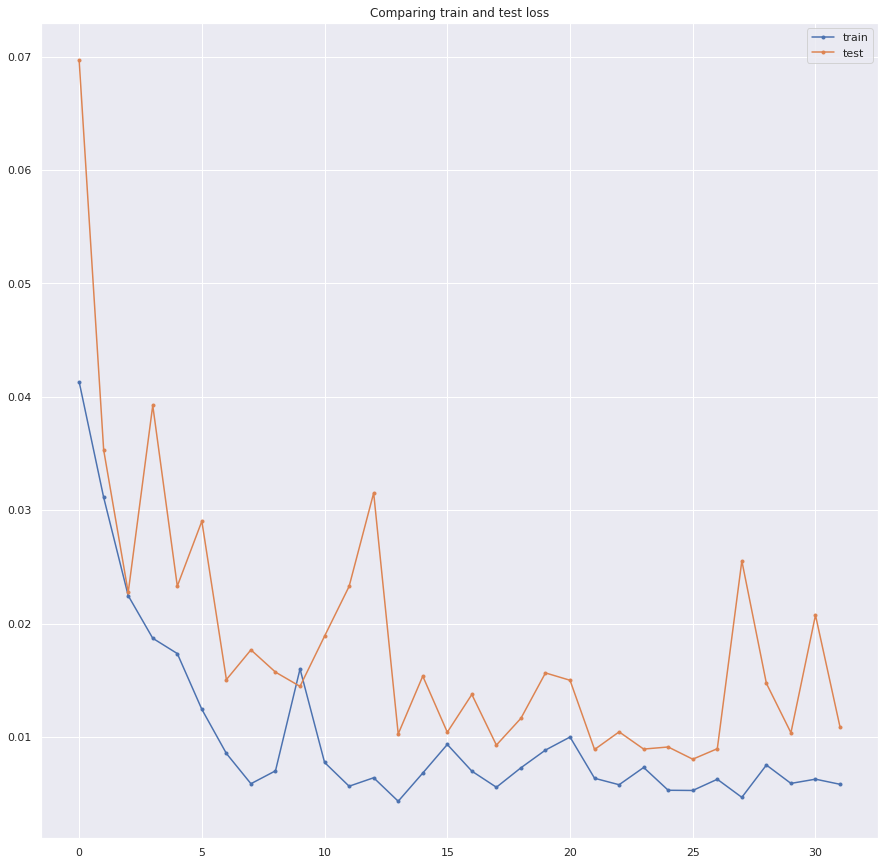

In [9]:
plt.figure(figsize=(15, 15))
plt.title('Comparing train and test loss')
plt.plot(history_train[:, 0], marker='.', label='train')
plt.plot(history_test[:, 0], marker='.', label='test')
plt.legend()
plt.show()

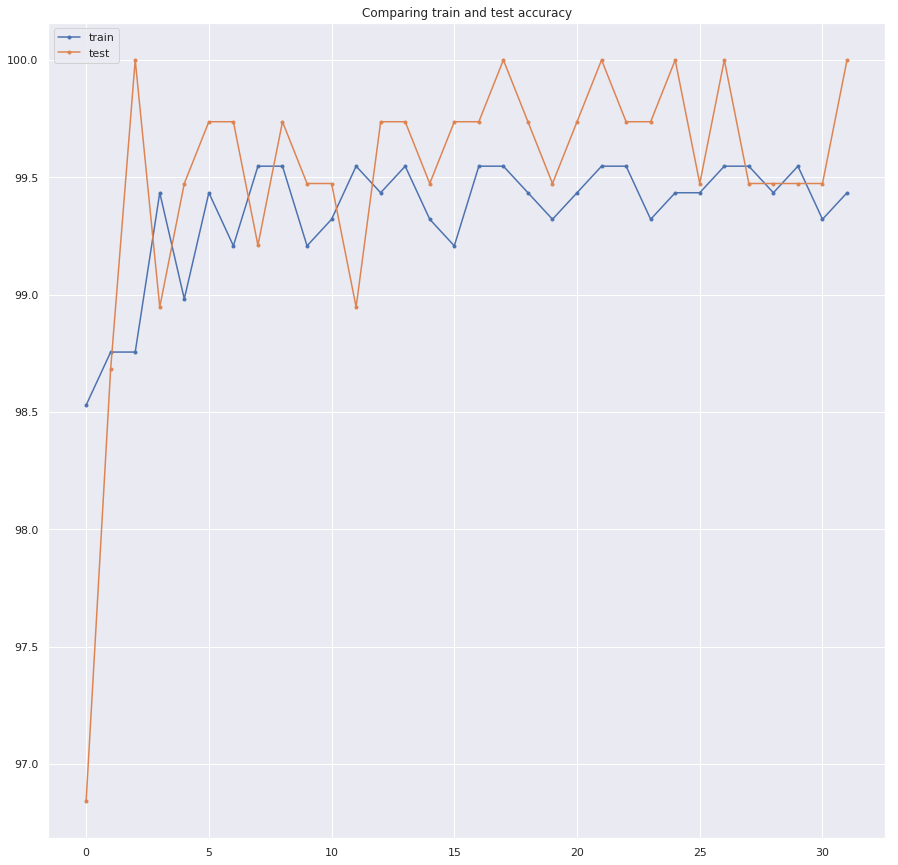

In [10]:
plt.figure(figsize=(15, 15))
plt.title('Comparing train and test accuracy')
plt.plot(history_train[:, 1], marker='.', label='train')
plt.plot(history_test[:, 1], marker='.', label='test')
plt.legend()
plt.show()

In [11]:
def prediction(data_loader):
    model.eval()
    test_pred = torch.LongTensor()
    
    with torch.no_grad():
        for images in data_loader:
            images = images.to(device)

            outputs = model(images)

            pred = outputs.cpu().data.max(1, keepdim=True)[1]

            test_pred = torch.cat((test_pred, pred), dim=0)

    return test_pred

def prediction_(data_loader):
    model.eval()
    test_pred = torch.LongTensor()
    
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)

            outputs = model(images)

            pred = outputs.cpu().data.max(1, keepdim=True)[1]

            test_pred = torch.cat((test_pred, pred), dim=0)

    return test_pred

In [12]:
y_test = []
for _, label in test_loader:
    y_test.extend(label.cpu().numpy().ravel())

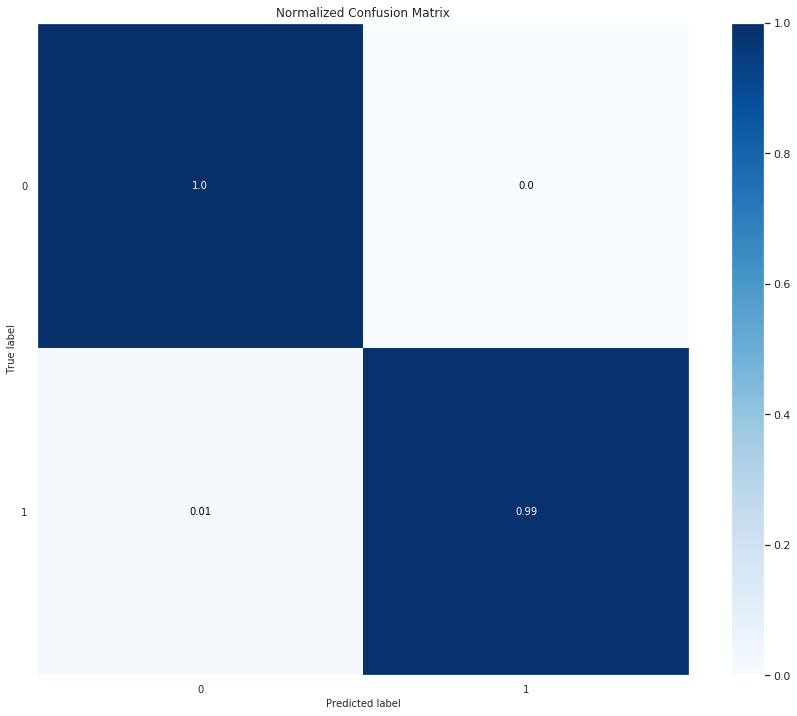

In [13]:
import scikitplot

scikitplot.metrics.plot_confusion_matrix(y_test, prediction_(test_loader), normalize=True, figsize=(15, 12))
plt.show()

In [14]:
from sklearn.manifold import TSNE

final = model._modules.get('fc')
inputs = []

def collect_inputs(m, i, o):
    inputs.append(i)
    
hs = final.register_forward_hook(collect_inputs)

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        model(images)
        
hs.remove()

In [15]:
inputs = np.array(inputs)

new_x = []
for elem in inputs:
    for _ in elem[0]:
        new_x.append(np.array(_.cpu()))
        
new_x = np.array(new_x)

In [16]:
x_transformed = TSNE().fit_transform(new_x)

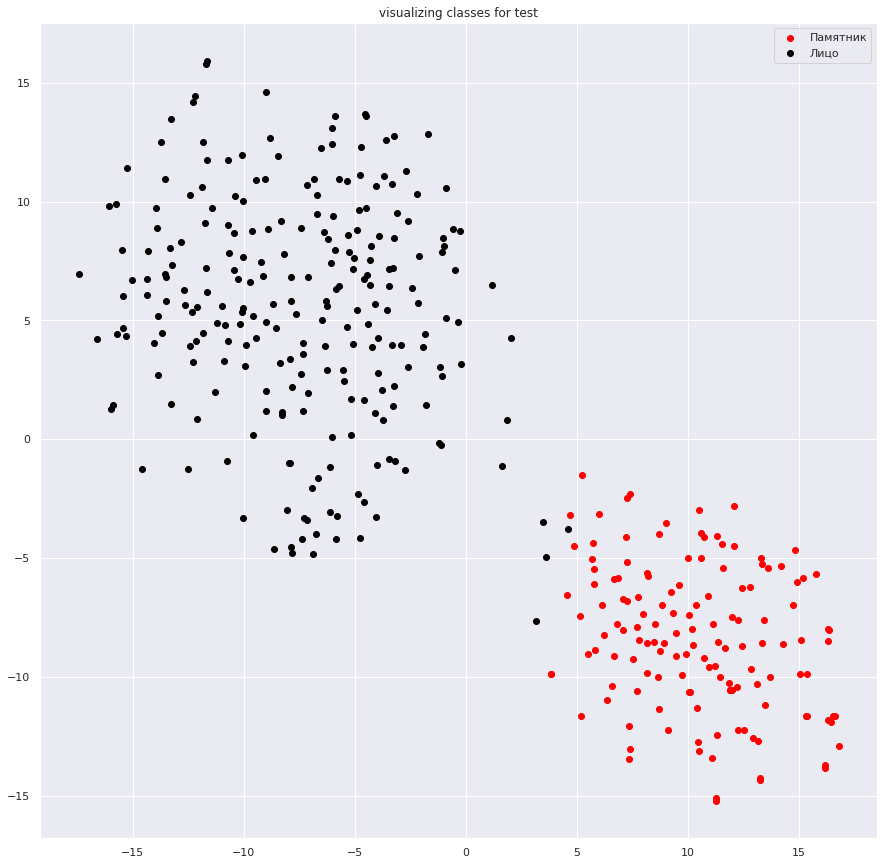

In [17]:
colors = ['red', 'black']
names = ['Памятник', 'Лицо']

plt.figure(figsize=(15, 15))
plt.title('visualizing classes for test')

for i in range(2):
    mask = np.array(y_test) == i
    plt.scatter(x_transformed[:, 1][mask], x_transformed[:, 0][mask], label=names[i], color=colors[i])
plt.legend()
plt.show()

In [18]:
with torch.no_grad():
    for images, labels, filenames in whole_loader:
        images = images.to(device)

        outputs = model(images)

        pred = outputs.cpu().data.max(1, keepdim=True)[1]
        
        for i in range(len(labels)):
            if pred[i] != labels[i]:
                print(filenames[i])